In [1]:
import os
import re

from sklearn import preprocessing

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

from pandas.plotting import scatter_matrix

import warnings
warnings.filterwarnings("ignore") 

%run model.py
%run plotPerformance.py
%run paramPipeline.py

%matplotlib inline

np.random.seed(1234)

# Load Data

In [2]:
# Load transformed data
cwd = os.getcwd()
datadir = cwd + os.sep + 'data' + os.sep

data = pd.read_csv(datadir + "complete.csv", index_col = 0)

# Feature Selection

In [3]:
#Drop reputation-based features
data2 = data.drop(["followers_count", "friends_count"], axis = 1)

In [4]:
#Drop highly correlated features
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] >= threshold:
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    return(dataset)

#Ignore mv features
mv_cols = list(data.filter(like='mv').columns)
mv_cols = [x for x in mv_cols if data[x].max() <= 1]
data_mv = data[data.columns.difference(mv_cols)]

data3 = correlation(data_mv, 0.75)

In [5]:
#three models to test the datasets
dt_data = DecisionTreeClassifier(criterion="entropy")
lr_data = LogisticRegression()

data_choosers = {'data': data, 'data2': data2, 'data3': data3}

kfolds = KFold(10, True, random_state = 1234)


In [6]:
#Choose data set with highest mean auc
for dataset in data_choosers:
    aucs = list(cross_val_score(dt_data, data_choosers[dataset].drop('label',1), data_choosers[dataset].label, cv = kfolds, scoring="roc_auc"))
    aucs.extend(cross_val_score(lr_data, data_choosers[dataset].drop('label',1), data_choosers[dataset].label, cv = kfolds, scoring="roc_auc"))
    
    print("For {0}, mean auc is {1}:".format(dataset, np.round(np.mean(aucs), decimals = 3))) 

For data, mean auc is 0.714:
For data2, mean auc is 0.719:
For data3, mean auc is 0.704:


In [7]:
# Train test split
X_train, X_test, y_train, y_test = ms.train_test_split(data2.drop('label', 1), data2.label, test_size=0.2, random_state = 1234)

In [8]:
dt = Model("Decision Tree", DecisionTreeClassifier(criterion="entropy"), X_train, y_train, X_test, y_test)

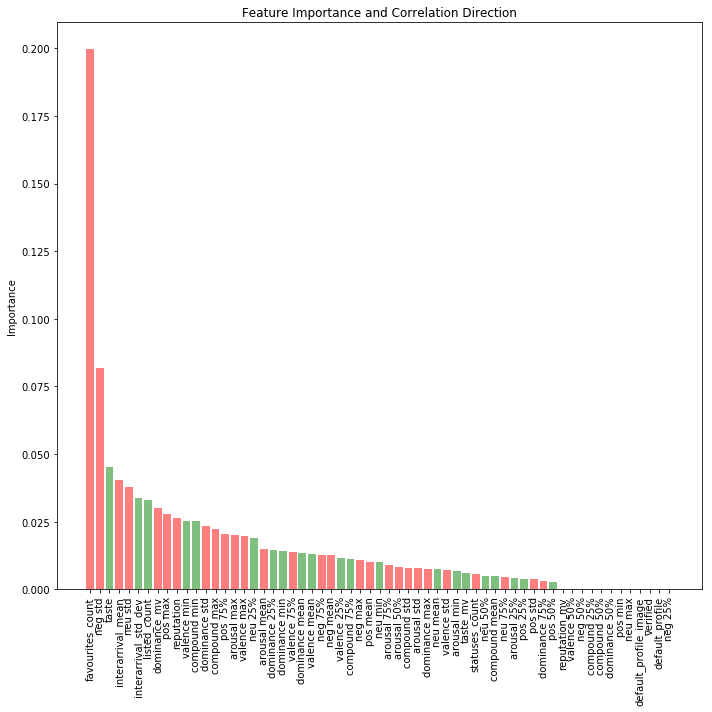

In [9]:
# Get importance and correlation
features_summary = pd.DataFrame(list(zip(X_train.columns, dt.best_iteration.model.feature_importances_)), 
                                columns=['feature','importance']).set_index('feature')
features_summary = features_summary.sort_values('importance', ascending=False)

corr_df = pd.DataFrame(data.corr()['label'].drop('label'))
corr_df.columns = ['correlation']

features_summary = features_summary.merge(corr_df, right_index=True, left_index=True)
features_summary['colors'] = 'r'
features_summary.loc[features_summary.correlation > 0,'colors'] = 'g'

fig_feat, ax_feat = plt.subplots(1,1) 
fig_feat.set_size_inches(10, 10)

y_pos = np.arange(features_summary.shape[0])
plt.bar(y_pos, features_summary.importance, align='center', alpha=0.5, color=features_summary.colors)
plt.xticks(y_pos, features_summary.index, rotation='vertical')
plt.title('Feature Importance and Correlation Direction')
plt.ylabel('Importance')

plt.tight_layout()
plt.show()

# Select features
keep_features = features_summary[features_summary.importance > 0].index.values

# EDA

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1b3a9e10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a21b841d0>]], dtype=object)

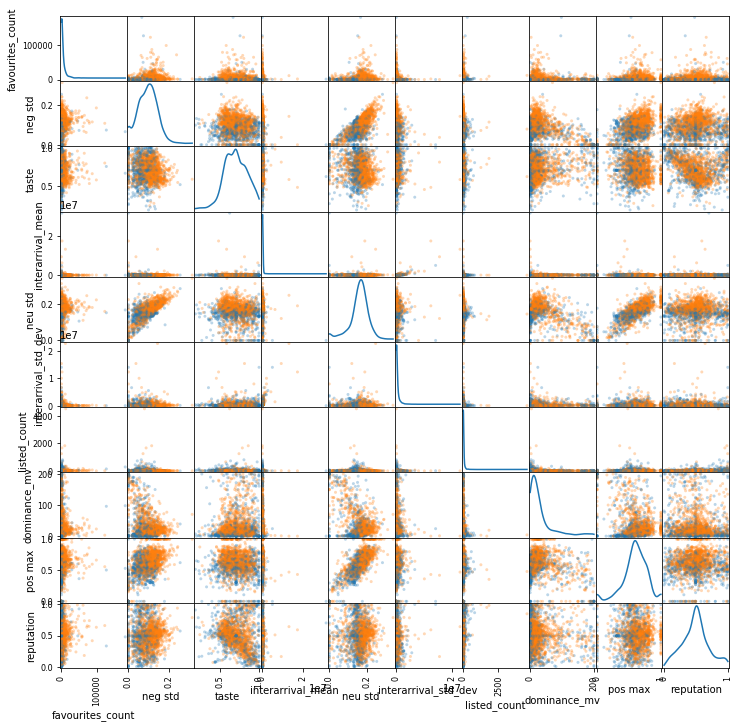

In [10]:
eda_data = X_train.copy()
eda_y = y_train.copy()

scatter_matrix(eda_data[features_summary.head(10).index], alpha=0.3, figsize=(12, 12), diagonal='kde',
              color=np.where(eda_y==1,'C0','C1'))

# Train Baseline Model

In [11]:
# Discard features
X_train_filt = X_train[keep_features]
X_test_filt = X_test[keep_features]

#Scale scalable features
scalable = X_train_filt[X_train_filt.columns.difference(mv_cols)].select_dtypes(exclude = ["bool"]).columns
scaler = preprocessing.StandardScaler()
scaler.fit(X_train_filt[scalable].copy())

X_trained = X_train_filt.copy()
X_tested = X_test_filt.copy()

X_trained[scalable] = scaler.transform(X_trained[scalable])
X_tested[scalable] = scaler.transform(X_tested[scalable])

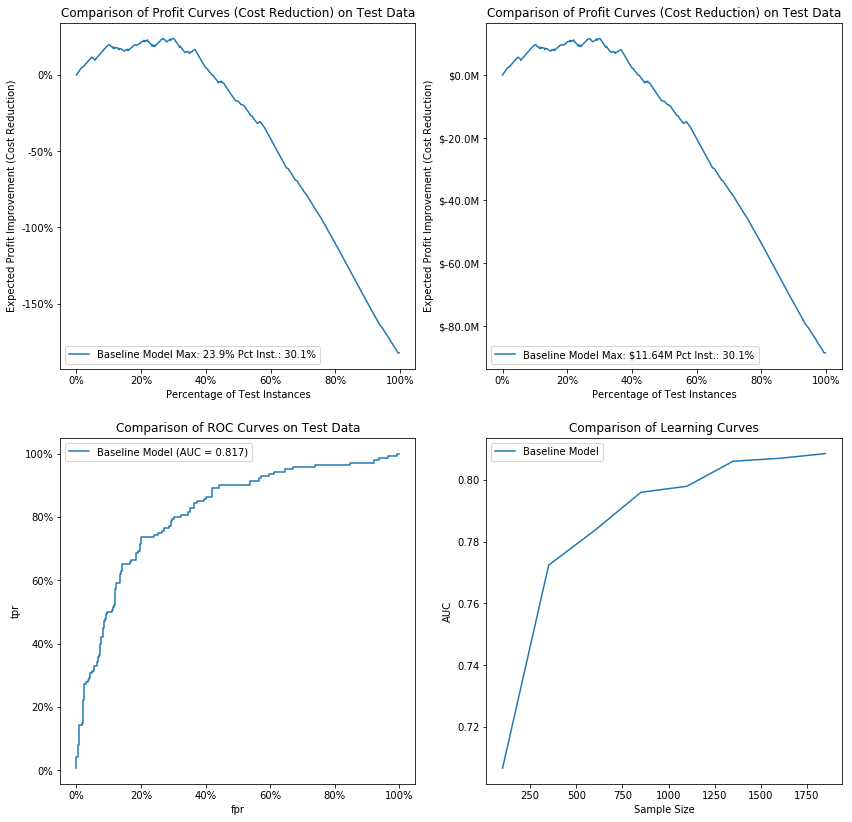

In [12]:
# Baseline Logistic Regression and SVM
lr = Model("Baseline Model", LogisticRegression(), X_trained, y_train, X_tested, y_test)
plotPerformance([lr], list(range(100,2000,250)), 20)

### Pipelines

# Logistic Regression

## Model Initialization

In [13]:
lrc = Model("LR", LogisticRegression(), X_trained, y_train, X_tested, y_test)

## Iteration 1

In [14]:
lrc_estimator = Pipeline([('poly', PolynomialFeatures()),
                          ('estimator', LogisticRegression())])

lrc.addIteration("C", lrc_estimator, 
                 {'poly__degree': [1,2],
                  'estimator__C': [10**x for x in range(-8,5)]}, 
                 reg = True, plot = False)

lrc.parameters

Best Score: 0.802664

Best Params:  {'estimator__C': 0.01, 'poly__degree': 2}


{}

# SVM

## Model Initialization

In [15]:
svm =  Model("SVM", SVC(probability = True), X_trained, y_train, X_tested, y_test)

svm.parameters['probability'] = True

## Iteration 1

In [16]:
svm.addIteration("Kernel", SVC(**svm.parameters), 
                 {'kernel': ['linear','rbf','sigmoid']}, 
                 plot = False)

svm.parameters

Best Score: 0.834601

Best Params:  {'kernel': 'rbf'}


{'kernel': 'rbf', 'probability': True}

## Iteration 2

Best Score: 0.834601

Best Params:  {'C': 1}


{'C': 1, 'kernel': 'rbf', 'probability': True}

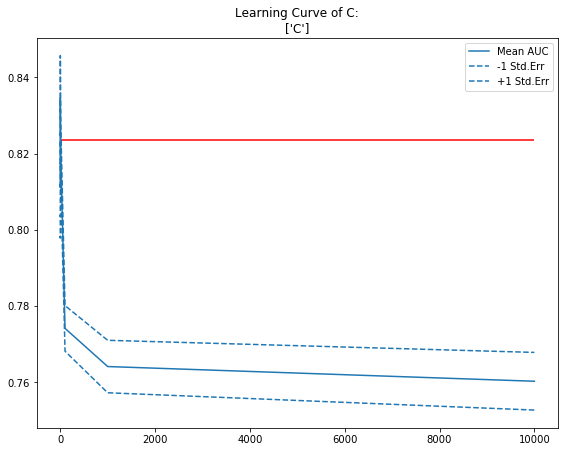

In [17]:
svm.addIteration("C", SVC(**svm.parameters), 
                {'C': [10**x for x in range(-8,5)]}, 
                 reg = True, plot = True)

svm.parameters

## SVM Compare

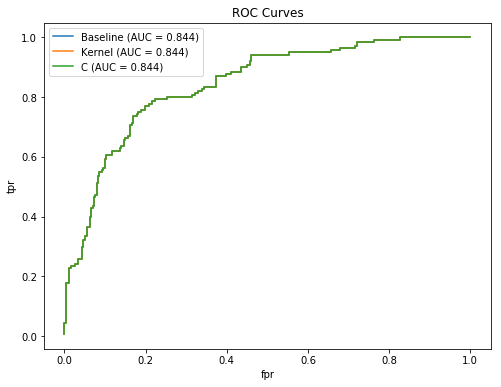

In [18]:
svm.withinCompare()

# GBM 

## Model Initialization

In [19]:
gbc = Model("GBC", GradientBoostingClassifier(), X_trained, y_train, X_tested, y_test)

 ## Iteration 1

Best Score: 0.85941

Best Params:  {'n_estimators': 50}


{'n_estimators': 30}

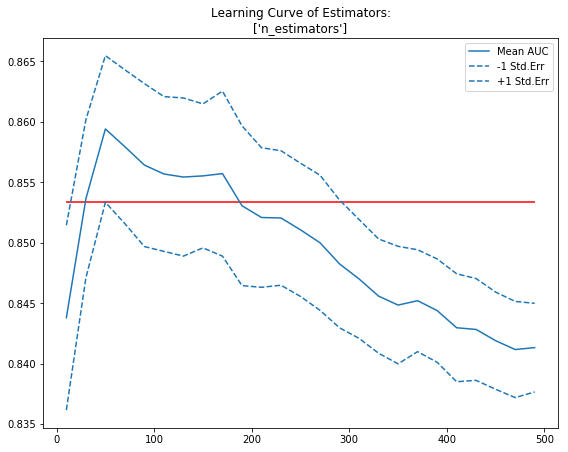

In [20]:
gbc.addIteration("Estimators", GradientBoostingClassifier(**gbc.parameters),
                {'n_estimators': list(range(10,500,20))}, 
                 reg = True, plot = True)
gbc.parameters

## Iteration 2 

Best Score: 0.854193

Best Params:  {'max_depth': 4}


{'max_depth': 2, 'n_estimators': 30}

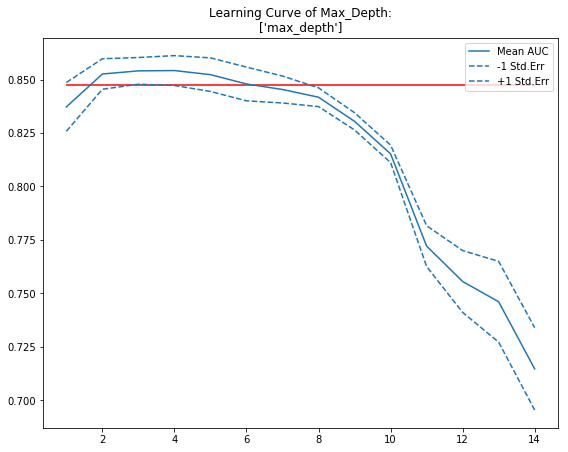

In [21]:
gbc.addIteration("Max_Depth", GradientBoostingClassifier(**gbc.parameters),
                {'max_depth': list(range(1,15))}, 
                 reg = True, plot = True)

gbc.parameters['max_depth'] = 2
gbc.parameters

## Iteration 3

Best Score: 0.853681

Best Params:  {'min_samples_leaf': 80}


{'max_depth': 2, 'min_samples_leaf': 42, 'n_estimators': 30}

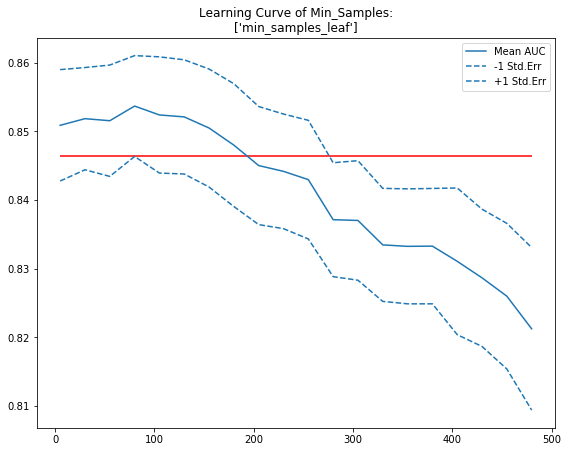

In [22]:
gbc.addIteration("Min_Samples", GradientBoostingClassifier(**gbc.parameters),
                {'min_samples_leaf': list(range(5,500,25))},
                 reg = True, plot = True)

gbc.parameters

## Iteration 4

Best Score: 0.853664

Best Params:  {'max_features': 14}


{'max_depth': 2, 'max_features': 8, 'min_samples_leaf': 42, 'n_estimators': 30}

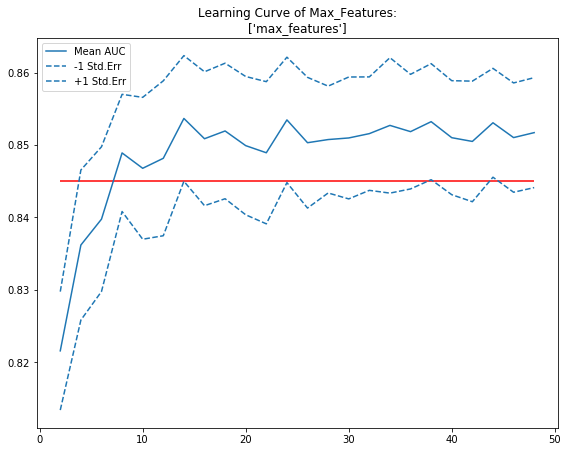

In [23]:
gbc.addIteration("Max_Features", GradientBoostingClassifier(**gbc.parameters),
                {'max_features': list(range(2,X_trained.shape[1],2))}, 
                 reg = True, plot = True)

gbc.parameters

## Iteration 5

Best Score: 0.849611

Best Params:  {'subsample': 1.0}


{'max_depth': 2,
 'max_features': 8,
 'min_samples_leaf': 42,
 'n_estimators': 30,
 'subsample': 1.0}

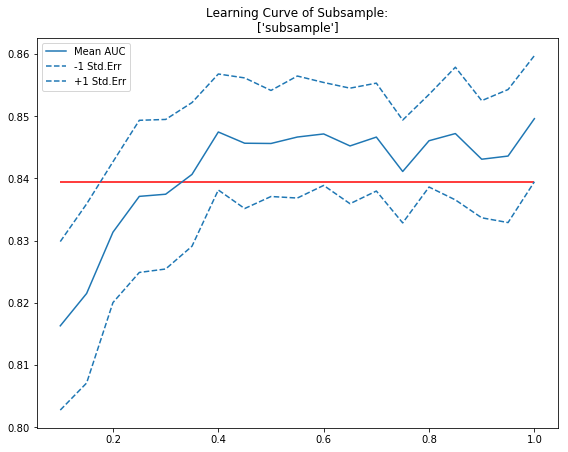

In [24]:
gbc.addIteration("Subsample", 
                GradientBoostingClassifier(**gbc.parameters),
                {'subsample': np.array(list(range(10,105,5)))/100}, 
                des = False, reg = True, plot = True)

gbc.parameters

## Interation 6 

Best Score: 0.860756

Best Params:  {'learning_rate': 0.01, 'n_estimators': 910}


{'learning_rate': 0.01,
 'max_depth': 2,
 'max_features': 8,
 'min_samples_leaf': 42,
 'n_estimators': 810,
 'subsample': 1.0}

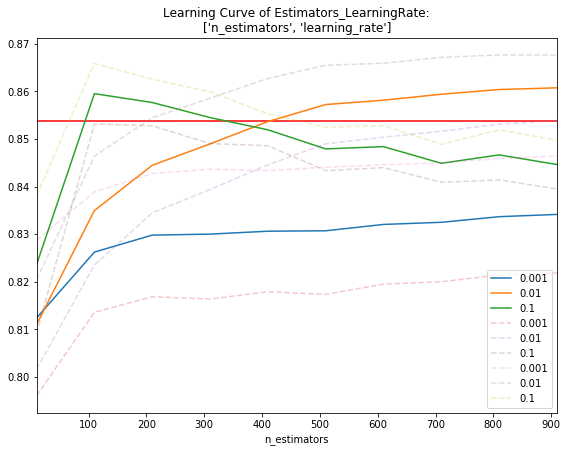

In [25]:
gbc.addIteration("Estimators_LearningRate",
                GradientBoostingClassifier(**gbc.parameters),
                {'n_estimators': list(range(10,1000,100)),
                 'learning_rate': [10**x for x in range(-3,0)]}, 
                 reg = True, plot = True)

gbc.parameters

## Iteration 7

Best Score: 0.861737

Best Params:  {'n_estimators': 1000}


{'learning_rate': 0.01,
 'max_depth': 2,
 'max_features': 8,
 'min_samples_leaf': 42,
 'n_estimators': 900,
 'subsample': 1.0}

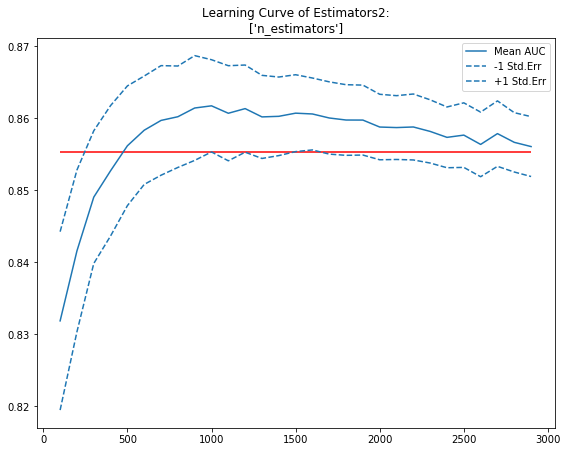

In [26]:
gbc.addIteration("Estimators2", 
                GradientBoostingClassifier(**gbc.parameters),
                {'n_estimators': list(range(100,3000,100))},
                reg = True, plot = True)

gbc.parameters

## GBC Compare 

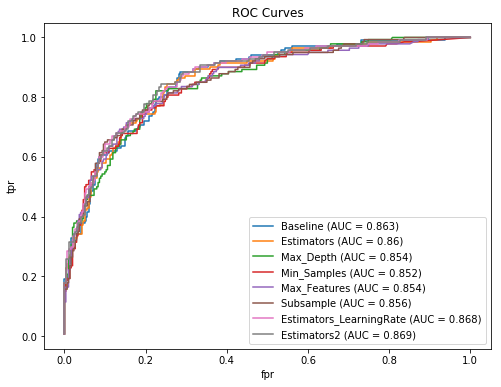

In [27]:
gbc.withinCompare()

# Random Forest

## Model Initialization

In [28]:
rdf = Model("RDF", RandomForestClassifier(), X_trained, y_train, X_tested, y_test)

## Iteration 1

Best Score: 0.857689

Best Params:  {'n_estimators': 446}


{}

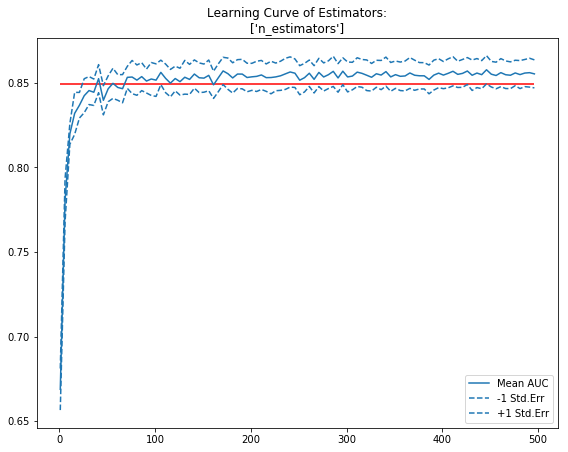

In [29]:
rdf.addIteration("Estimators", RandomForestClassifier(),
                {'n_estimators': list(range(1,500,5))}, 
                reg = True, plot = True)

rdf.parameters

## Iteration 2

Best Score: 0.833682

Best Params:  {'max_features': 22}


{}

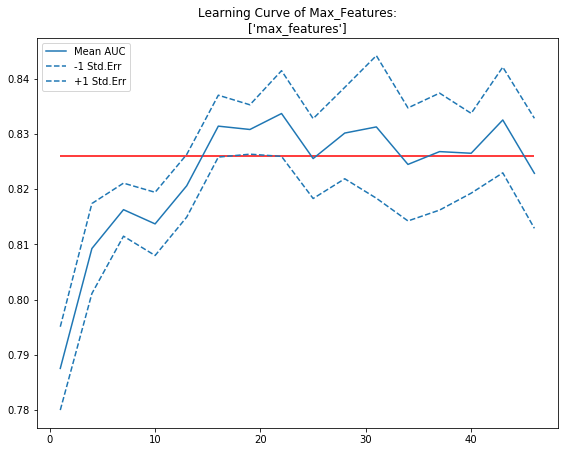

In [30]:
rdf.addIteration("Max_Features", RandomForestClassifier(**rdf.parameters),
                {'max_features': list(range(1,X_trained.shape[1],3))}, 
                reg = True, plot = True)

rdf.parameters

## Iteration 3

Best Score: 0.842742

Best Params:  {'min_samples_leaf': 18}


{'min_samples_leaf': 14}

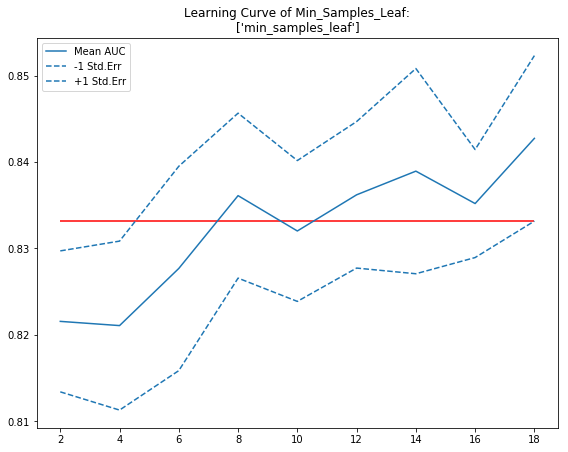

In [31]:
rdf.addIteration("Min_Samples_Leaf", RandomForestClassifier(**rdf.parameters),
                {'min_samples_leaf': list(range(2,20,2))}, 
                reg = True, plot = True)

rdf.parameters

## Iteration 4

Best Score: 0.8426

Best Params:  {'min_samples_split': 36}


{'min_samples_leaf': 14, 'min_samples_split': 20}

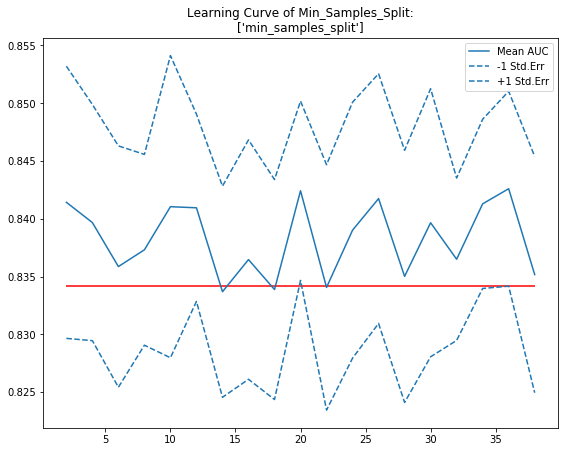

In [32]:
rdf.addIteration("Min_Samples_Split", RandomForestClassifier(**rdf.parameters),
                {'min_samples_split':list(range(2,40,2))}, 
                 reg = True, plot = True)

rdf.parameters

## Compare RDF

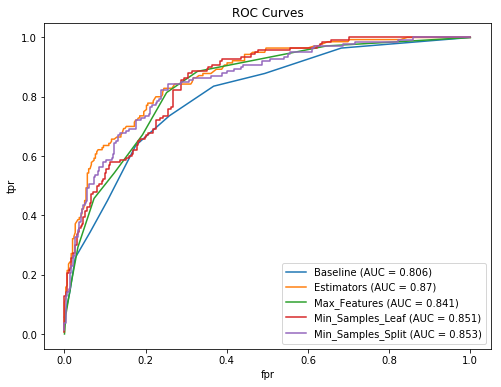

In [33]:
rdf.withinCompare()

# Dimension Reduction

## EDA

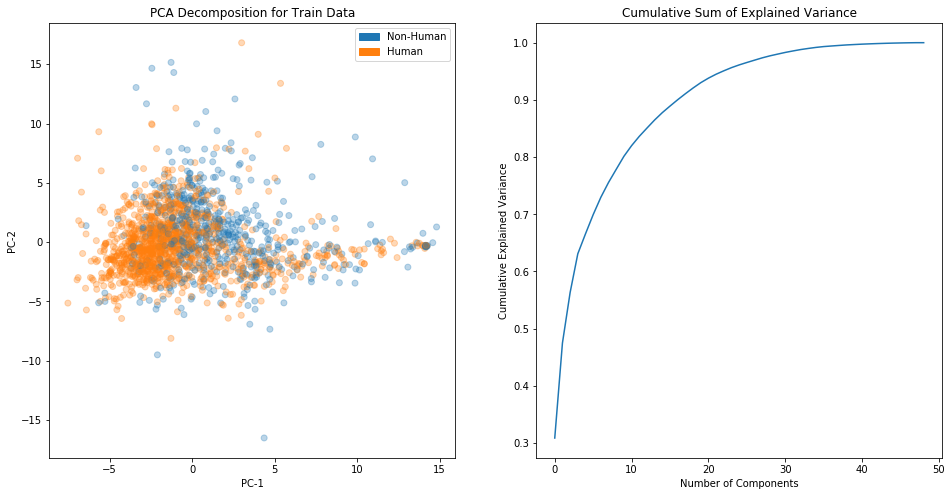

In [34]:
pca_eda = PCA()
pca_eda.fit(X_trained)

pc = pd.DataFrame(pca_eda.fit_transform(X_trained), index = X_trained.index)
pc = pc.join(y_train)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,8))
ax1.scatter(pc.iloc[:,0],
            pc.iloc[:,1],
            color=['C0' if x==1 else 'C1' for x in pc['label']],
            alpha=0.3)

ax1.set_title("PCA Decomposition for Train Data")
ax1.set_xlabel("PC-1")
ax1.set_ylabel("PC-2")
orange_patch = mpatches.Patch(color='C0', label='Non-Human')
blue_patch = mpatches.Patch(color='C1', label='Human')
ax1.legend(handles=[orange_patch, blue_patch])

ax2.plot(pca_eda.explained_variance_ratio_.cumsum())
ax2.set_title("Cumulative Sum of Explained Variance")
ax2.set_xlabel("Number of Components")
ax2.set_ylabel("Cumulative Explained Variance")

## Model Initialization

In [35]:
gbc_pca_estimator = Pipeline(steps=[('pca', PCA(whiten = True)), 
                                    ('gbc', GradientBoostingClassifier())])

gbc_pca = Model("Reduced GBC", gbc_pca_estimator, X_trained, y_train, X_tested, y_test)

## Iteration 1

Best Score: 0.830652

Best Params:  {'pca__n_components': 43}


{'gbc': {}, 'pca': {'n_components': 43}}

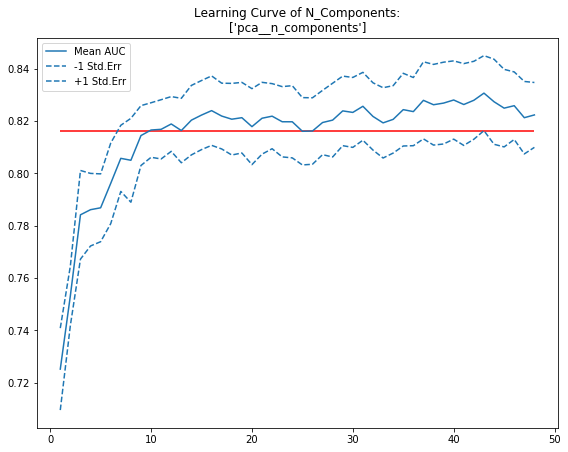

In [36]:
gbc_pca.addIteration("N_Components", gbc_pca_estimator, 
                     {'pca__n_components' : list(range(1,X_trained.shape[1]))}, 
                     reg = False, plot = True)

gbc_pca.parameters

## Iteration 2

Best Score: 0.831378

Best Params:  {'gbc__n_estimators': 230}


{'gbc': {'n_estimators': 230}, 'pca': {'n_components': 43}}

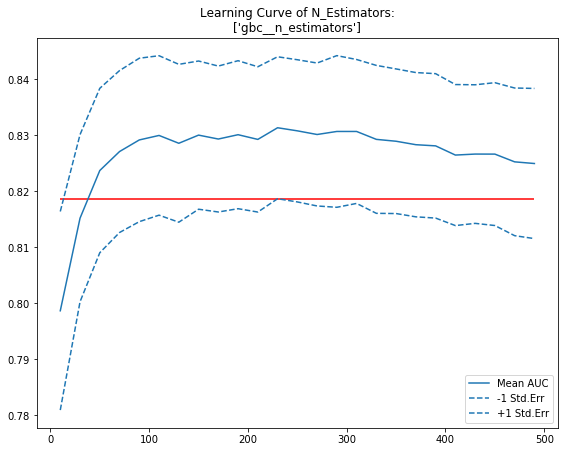

In [37]:
gbc_pca_estimator = Pipeline(steps=[('pca', PCA(**gbc_pca.parameters['pca'])), 
                                    ('gbc', GradientBoostingClassifier(**gbc_pca.parameters['gbc']))])

gbc_pca.addIteration("N_Estimators", gbc_pca_estimator, 
                     {'gbc__n_estimators' : list(range(10,500,20))}, 
                     reg = False, plot = True)

gbc_pca.parameters

## Iteration 3

Best Score: 0.831163

Best Params:  {'gbc__max_depth': 3}


{'gbc': {'max_depth': 3, 'n_estimators': 230}, 'pca': {'n_components': 43}}

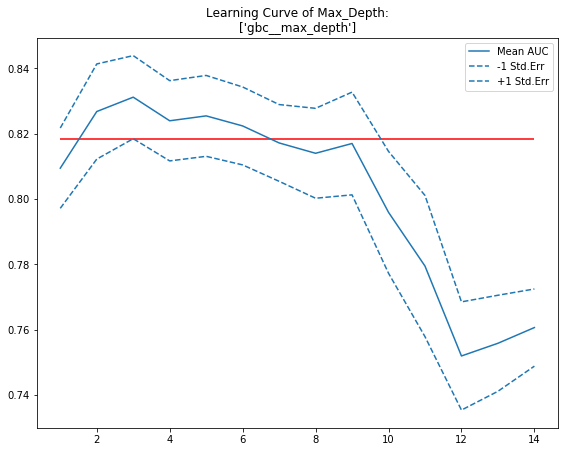

In [38]:
gbc_pca_estimator = Pipeline(steps=[('pca', PCA(**gbc_pca.parameters['pca'])), 
                                    ('gbc', GradientBoostingClassifier(**gbc_pca.parameters['gbc']))])

gbc_pca.addIteration("Max_Depth", gbc_pca_estimator, 
                     {'gbc__max_depth' : list(range(1,15))}, 
                     reg = False, plot = True)

gbc_pca.parameters

## Iteration 4

Best Score: 0.827466

Best Params:  {'gbc__min_samples_leaf': 15}


{'gbc': {'max_depth': 3, 'n_estimators': 230}, 'pca': {'n_components': 43}}

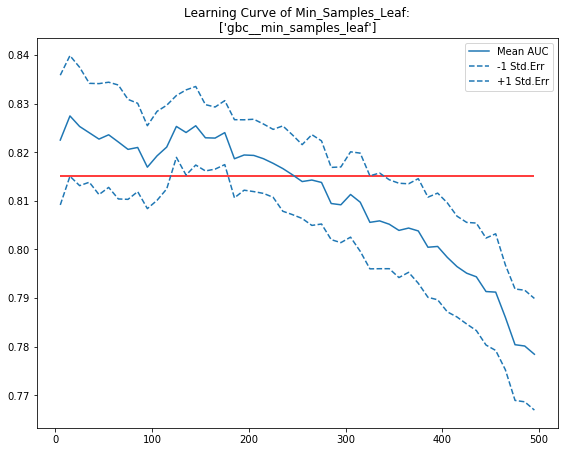

In [39]:
gbc_pca_estimator = Pipeline(steps=[('pca', PCA(**gbc_pca.parameters['pca'])), 
                                    ('gbc', GradientBoostingClassifier(**gbc_pca.parameters['gbc']))])

gbc_pca.addIteration("Min_Samples_Leaf", gbc_pca_estimator, 
                     {'gbc__min_samples_leaf' : list(range(5,500,10))}, 
                     reg = False, plot = True)

gbc_pca.parameters

## Iteration 5

Best Score: 0.831065

Best Params:  {'gbc__subsample': 0.69999999999999996}


{'gbc': {'max_depth': 3,
  'n_estimators': 230,
  'subsample': 0.69999999999999996},
 'pca': {'n_components': 43}}

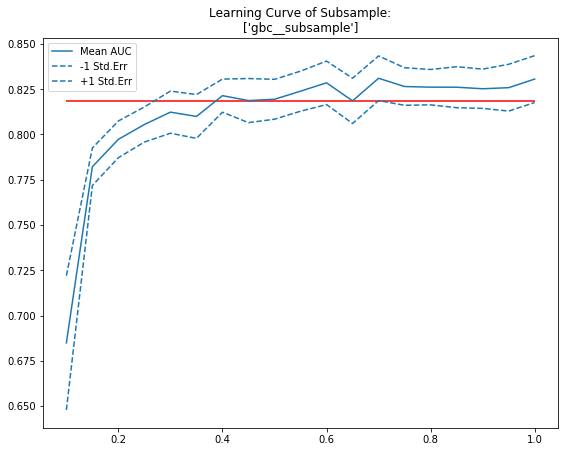

In [40]:
gbc_pca_estimator = Pipeline(steps=[('pca', PCA(**gbc_pca.parameters['pca'])), 
                                    ('gbc', GradientBoostingClassifier(**gbc_pca.parameters['gbc']))])

gbc_pca.addIteration("Subsample", gbc_pca_estimator, 
                     {'gbc__subsample' : np.array(list(range(10,105,5)))/100}, 
                     reg = False, plot = True)

gbc_pca.parameters

## Iteration 6

Best Score: 0.820716

Best Params:  {'gbc__learning_rate': 0.1}


{'gbc': {'learning_rate': 0.10000000000000001,
  'max_depth': 3,
  'n_estimators': 230,
  'subsample': 0.69999999999999996},
 'pca': {'n_components': 43}}

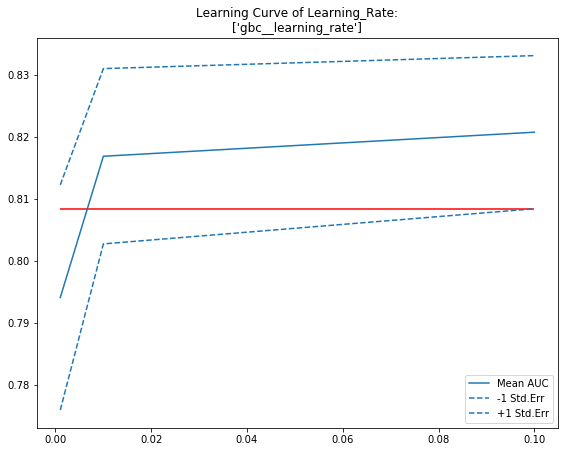

In [41]:
gbc_pca_estimator = Pipeline(steps=[('pca', PCA(**gbc_pca.parameters['pca'])), 
                                    ('gbc', GradientBoostingClassifier(**gbc_pca.parameters['gbc']))])

gbc_pca.addIteration("Learning_Rate", gbc_pca_estimator, 
                     {'gbc__learning_rate' : [10**x for x in range(-3,0)]}, 
                     reg = False, plot = True)

gbc_pca.parameters

## GBC_PCA Compare

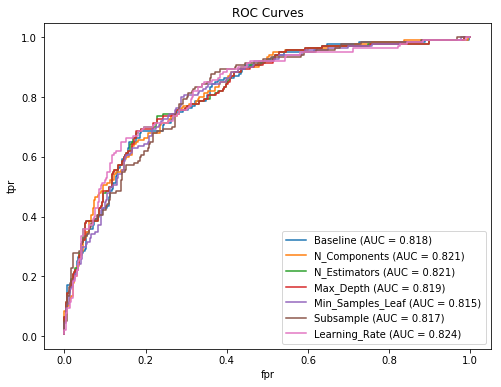

In [42]:
gbc_pca.withinCompare()

# LRC_PCA

## Model Initialization

In [43]:
lrc_pca_estimator = Pipeline(steps=[('pca', PCA(whiten = True)), 
                                    ('lrc', LogisticRegression())])

lrc_pca = Model("Reduced LRC", lrc_pca_estimator, X_trained, y_train, X_tested, y_test)

## Iteration 1

Best Score: 0.787284

Best Params:  {'pca__n_components': 37}


{'lrc': {}, 'pca': {'n_components': 37}}

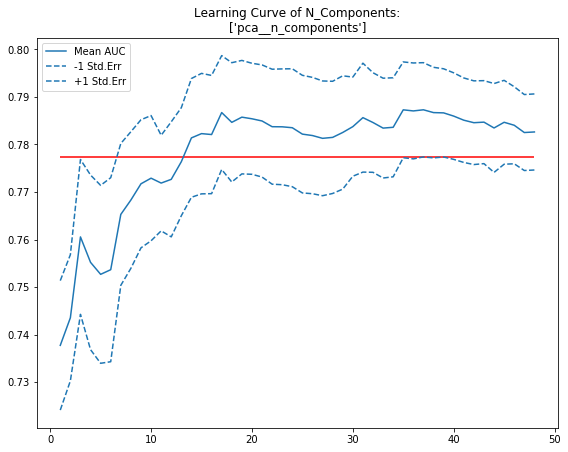

In [44]:
lrc_pca.addIteration("N_Components", lrc_pca_estimator, 
                     {'pca__n_components' : list(range(1,X_trained.shape[1]))}, 
                     reg = False, plot = True)

lrc_pca.parameters

## Iteration 2

Best Score: 0.787522

Best Params:  {'lrc__C': 100}


{'lrc': {'C': 100}, 'pca': {'n_components': 37}}

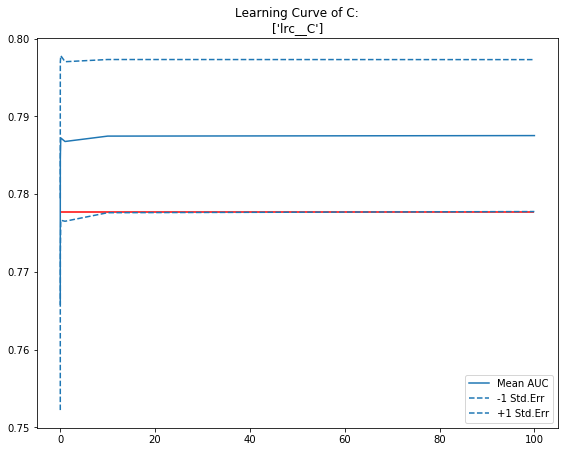

In [45]:
lrc_pca_estimator = Pipeline(steps=[('pca', PCA(**lrc_pca.parameters['pca'])), 
                                    ('lrc', LogisticRegression(**lrc_pca.parameters['lrc']))])

lrc_pca.addIteration("C", lrc_pca_estimator, 
                     {'lrc__C' : [10**x for x in range(-8,3)]}, 
                     reg = False, plot = True)

lrc_pca.parameters

## LRC_PCA Compare

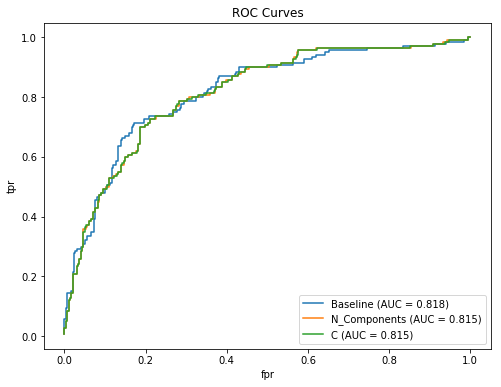

In [46]:
lrc_pca.withinCompare()

# Model Comparison


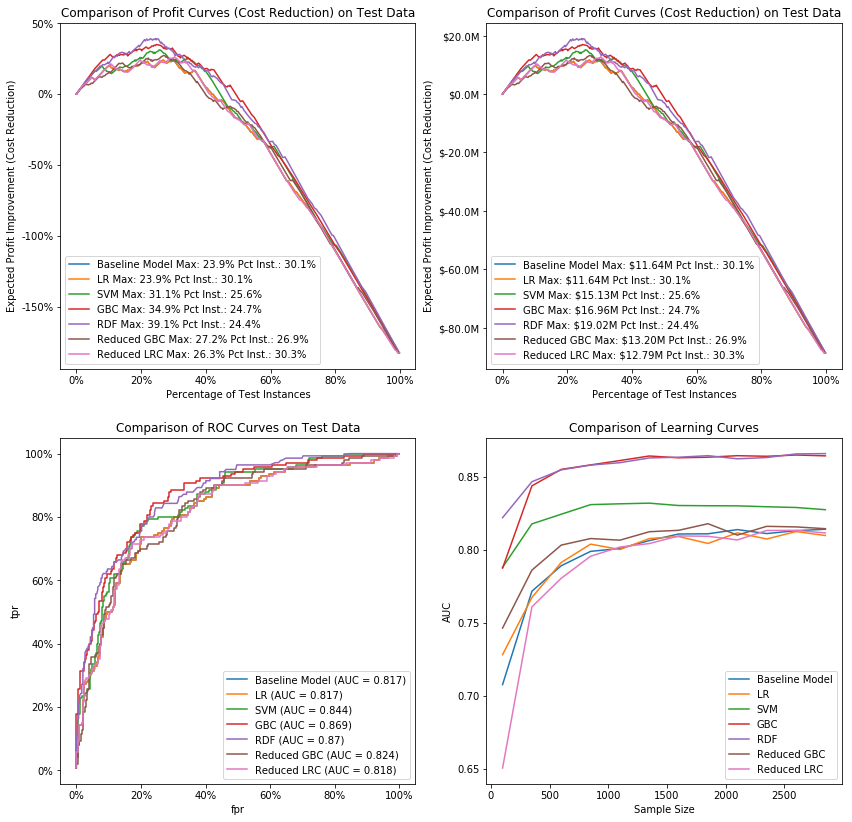

In [47]:
plotPerformance([lr, lrc, svm, gbc, rdf, gbc_pca, lrc_pca], list(range(100, 3000, 250)), 20)